In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from matplotlib import cm # colour map for pie chart
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, precision_score, confusion_matrix, classification_report, f1_score, make_scorer, precision_recall_curve, average_precision_score
from inspect import signature

plt.style.use('seaborn')
plt.rcParams.update({'figure.figsize': (10, 4)}) # Make figure size larger

# Prediction of adoption outcome in Animal Services
## Supervised binary classification models
### Author: AnaStasiaS-S



### Summary 

The purpose of this research is to predict weather the dog will be adopted from animal shelter using its characteristics (color, breed, gender, etc).



### Introduction

For the purposes of this research I took a dataset of [Louisville (KY, USA) Metro Open Data service](https://data.louisvilleky.gov/dataset/animal-service-intake-and-outcome) which provides data for the care and control of animals in the Louisville Metro area, USA. The dataset includes a list of all instances of animals brought into Animal Services with outcomes. 

We will read the data from csv file, clean it and make some exploratory data analysis. Afterwards we will train, tune and evaluate a few supervised machine learning algorithms: Logistic Regression, Trees and SVMs. 




# 1. Exploring Animal Services dataset


#### Data dictionary:

* Animal ID - A generated unique identification when an animal's information is stored in the Chameleon Data Base
* Animal Type - Type of animal
* Intake Date - The date that the animal arrives at Metro Animal Services
* Intake Type - The reason the animal is at Metro Animal Services
* Intake Subtype - A secondary but more in depth reason why the animal is at Metro Animal Services
* Primary Color - The color that is most prevalent in the animal
* Primary Breed - The breed of the animal or the breed the animal looks like the most
* Secondary Breed - The other breed that the animal looks like
* Gender - Sex of the animal
* Secondary Color - A further description of the animal's color
* DOB - The date of birth of the animal or an estimated date of birth
* Intake Reason - The primary reason the animal is at Metro Animal Services
* Outcome Date - The date the outcome is entered if no outcome date is available the animal is still in the shelter
* Outcome Type - The type of outcome for the animal that can include returned to owner, adoption, sent to a rescue, etc.
* Outcome Subtype - A secondary, more in depth definition of the outcome type (ex. Transfer, rescue group vs. Transfer, KHS)

### 1.1 Reading and exploaring the data 

In [3]:
animals_data = pd.read_csv("animal-service-intake-and-outcome.csv")
animals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150842 entries, 0 to 150841
Data columns (total 22 columns):
AnimalID                       150842 non-null object
AnimalType                     150842 non-null object
IntakeDate                     150842 non-null object
IntakeType                     150842 non-null object
IntakeSubtype                  146286 non-null object
PrimaryColor                   150825 non-null object
PrimaryBreed                   150842 non-null object
SecondaryBreed                 40532 non-null object
Gender                         150842 non-null object
SecondaryColor                 80579 non-null object
DOB                            94618 non-null object
IntakeReason                   34805 non-null object
IntakeInternalStatus           150842 non-null object
IntakeAsilomarStatus           150842 non-null object
ReproductiveStatusAtIntake     150842 non-null object
OutcomeDate                    150640 non-null object
OutcomeType                  

In [4]:
animals_data.head()

,AnimalID,AnimalType,IntakeDate,IntakeType,IntakeSubtype,PrimaryColor,PrimaryBreed,SecondaryBreed,Gender,SecondaryColor,...,IntakeInternalStatus,IntakeAsilomarStatus,ReproductiveStatusAtIntake,OutcomeDate,OutcomeType,OutcomeSubtype,OutcomeReason,OutcomeInternalStatus,OutcomeAsilomarStatus,ReproductiveStatusAtOutcome
0,A366370,CAT,2008-11-07 10:50:00,STRAY,OTC,WHITE,DOMESTIC SHORTHAIR,NaN,NEUTERED MALE,BROWN,...,FEARFUL,HEALTHY,ALTERED,2008-11-12 15:46:00,EUTH,FERAL,NaN,NaN,UNHEALTHY/UNTREATABLE,ALTERED
1,A366531,CAT,2008-11-10 10:20:00,STRAY,OTC,BLACK,DOMESTIC SHORTHAIR,DOMESTIC SHORTHAIR,UNKNOWN,NaN,...,NORMAL,HEALTHY,UNKNOWN,2008-11-19 20:10:00,EUTH,CONTAG DIS,NaN,SICK,HEALTHY,UNKNOWN
2,A532367,BIRD,2014-07-23 23:21:00,CONFISCATE,CRUELTY,RED,CHICKEN,NaN,MALE,BLACK,...,OTHER,HEALTHY,FERTILE,2014-11-05 15:49:00,TRANSFER,NaN,NaN,NaN,HEALTHY,FERTILE
3,A532474,OTHER,2014-07-24 18:29:00,ET REQUEST,NaN,BROWN,BAT,NaN,UNKNOWN,NaN,...,OTHER,HEALTHY,UNKNOWN,2014-07-24 23:59:00,EUTH,MEDICAL,NaN,OTHER,HEALTHY,UNKNOWN
4,A281756,DOG,2006-09-11 18:10:00,OWNER SUR,OTC,WHITE,PIT BULL TERRIER,NaN,MALE,BROWN,...,NORMAL,HEALTHY,FERTILE,2006-09-12 13:44:00,EUTH,TIME/SPACE,NaN,NaN,HEALTHY,FERTILE


### 1.2 Select only dogs animal type
As the dataset includes data of different types of animals, let's see which one is most popular.

In [5]:
def my_autopct(pct):
    '''
    Condition removal labels.
        
    Returns:
    - Floating-point number - labels the wedges with their numeric value
    '''
    return ('%1.1f%%' % pct) if pct > 1 else ''

In [6]:
def pie(dataset, group_column, chart_title):
    '''
    Plot a pie chart of array x.
    
    Parameters:
    - dataset (DataFrame)
    - group_column (str)
    - chart_title (str)
    
    Returns:
    A pie chart
    '''
    categories = None
    categories = dataset.groupby(group_column).size()
    categories = categories.sort_values(ascending = False)
    
    # use colour map do avoid repeating colours
    cs=cm.Set1(np.arange(9)/9.)
    plt.pie(categories, autopct=my_autopct, radius=1.00, pctdistance=0.50, textprops={'fontsize': 15}, 
        explode = (0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07), colors=cs) 
    # Makes the plot look circular
    plt.gca().set_aspect("equal")
    plt.title(chart_title, fontsize=20, loc="center")
    plt.legend(labels=categories.index, loc="center", bbox_to_anchor=(1.8, 0.5), prop={'size': 14})
    #plt.ticks().set_aspect("equal")
        
    plt.show()

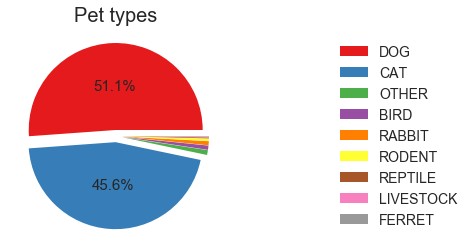

In [7]:
pie(animals_data, "AnimalType", "Pet types")

In [8]:
# Take the dogs records as a largest animal group

animals_data = animals_data[(animals_data.AnimalType == "DOG")]

### 1.3 Feature selection and engineering
As the purpose of this project is to classify **weather the pet will be adopted from animal shelter** we will keep only data concerning the pet characteristics as model features. Pet's age is an important one but this feature is only 60% fulfilled (includes register date instead of birth date in a large number of cases), that is why it will be dropped. Therefore the features will be:
1. `PrimaryColor` as dog color;
2. `PrimaryBreed` as dog breed;
3. `Gender` as dog gender;
4. `OutcomeAsilomarStatus` as health status;
5. `OutcomeType` as a label column.

The nest step is to explore each of these features.

In [9]:
# Select pet feature columns and make column names "pythonic":

animals_data = animals_data[[
    'PrimaryColor', 
    'PrimaryBreed', 
    'Gender',
    'OutcomeAsilomarStatus',
    'OutcomeType'
]]

# Rename columns

animals_data.columns = ['color', 'breed', 'gender', 'health_status', 'outcome_type']

In [10]:
# See the result dataset

animals_data.head()

,color,breed,gender,health_status,outcome_type
4,WHITE,PIT BULL TERRIER,MALE,HEALTHY,EUTH
6,BROWN,AMERICAN PIT BULL TERRIER,MALE,HEALTHY,EUTH
8,WHITE,LABRADOR RETRIEVER,MALE,HEALTHY,EUTH
15,TRICOLOR,BEAGLE,NEUTERED MALE,HEALTHY,EUTH
17,WHITE,PIT BULL TERRIER,MALE,HEALTHY,EUTH


In [11]:
animals_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77145 entries, 4 to 150839
Data columns (total 5 columns):
color            77131 non-null object
breed            77145 non-null object
gender           77145 non-null object
health_status    77008 non-null object
outcome_type     76905 non-null object
dtypes: object(5)
memory usage: 3.5+ MB


As seen the dataset has 77145 records with a little number of null values, which will be removed. Afterwards we will explore and clean each column one by one. 

In [12]:
# Drop the rows where at least one element is missing and UKNOWN values. Check the final number of records:

animals_data.dropna(inplace = True)
animals_data = animals_data[(animals_data != 'UNKNOWN').all(axis=1)]
animals_data.breed.size

75700

### 1.4 Explore pet color column

Here are the most common pet color types:

In [13]:
def barh(dataset, group_column, chart_title, xlabel_title):
    categories = None
    chart_by_category = None
    '''
    Draw horizontal bar chart for first 15 grouped values of selected column
    
    Parameters:
    - dataset (DataFrame) 
    - group_column (str)
    - chart_title (str)
    - xlabel_title (str)
    
    Returns:
    horizontal bar chart
    '''
    categories = dataset.groupby(group_column).size()
    categories = categories.sort_values().tail(15)
    
    y_pos = np.arange(len(categories.index))
    chart_by_category = plt.barh(y_pos,categories)
    plt.xlabel(xlabel_title, fontsize=13)
    plt.yticks(y_pos, categories.index, fontsize=10)
    plt.title(chart_title, fontsize = 20)
    plt.show()

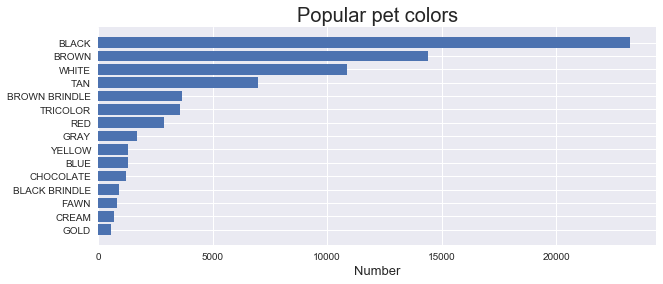

In [14]:
barh(animals_data, 'color', 'Popular pet colors', 'Number')

In [15]:
animals_data.color.unique()

array(['WHITE', 'BROWN', 'TRICOLOR', 'BROWN BRINDLE', 'TAN', 'BLACK',
       'RED', 'CHOCOLATE', 'CREAM', 'BLUE MERLE', 'FAWN', 'YELLOW',
       'GRAY', 'BLACK BRINDLE', 'LIVER', 'BLUE', 'BUFF', 'GOLD',
       'BROWN MERLE', 'PINK', 'SILVER', 'SABLE', 'BLUE CREAM',
       'BLUE TIGER', 'APRICOT', 'RED MERLE', 'BLONDE', 'BRINDLE',
       'BLACK TIGER', 'BROWN TIGER', 'BEIGE', 'YELLOW BRINDLE',
       'BLACK SMOKE', 'ORANGE', 'BLUE TICKED', 'CREAM TIGER', 'CHAMPAIGN',
       'RUDDY', 'TORTIE POINT', 'SEAL POINT', 'RED TICKED', 'BLUE SMOKE',
       'MERLE', 'BROWN TABBY', 'ORANGE TIGER', 'GRAY TIGER'], dtype=object)

As seen, most popular are pets with black color. On the other hand, there are many colors that repeat in different kind of variations, I will group them into several major groups: "BLACK", "WHITE", "BLUE", "GRAY", "BEIGE", "BROWN", "ORANGE", "YELLOW", "RED", "PURPLE", "MULTICOLOR". So all the color variations shown below would be roughly grouped into "MULTICOLOR" (even if they are two-color or tortoise):

![color](tortie-varieties-cats.jpg "COLORS")

In [16]:
# Rename colours
# !!! REMOVE unnecasary

# animals_data.color.replace({
#     'BROWN TABBY': 'BROWN', 
#     'BLACK TIGER': 'BLACK',
#     'BROWN BRINDLE': 'BROWN',
#     'TAN': 'BROWN',
#     'CALICO':'MULTICOLOR',
#     'GRAY TIGER':'GRAY',
#     'TORTIE':'MULTICOLOR',
#     'CHOCOLATE':'BROWN',
#     'GRAY TABBY':'GRAY',
#     'BUFF':'BROWN',
#     'CREAM':'BEIGE',
#     'ORANGE TIGER':'ORANGE',
#     'ORANGE TABBY':'ORANGE',
#     'BLUE MERLE':'BLUE',
#     'SILVER TIGER':'GRAY',
#     'BROWN TIGER':'BROWN',
#     'BLACK TABBY':'BLACK',
#     'FAWN':'YELLOW',
#     'CHOCOLATE POINT':'BROWN',
#     'BLACK BRINDLE':'BLACK',
#     'LYNX POINT':'CREAM',
#     'LIVER':'BROWN',
#     'BLACK SMOKE':'BLACK',
#     'SILVER TABBY':'GRAY',
#     'FLAME POINT':'YELLOW',
#     'GOLD':'YELLOW',
#     'BROWN MERLE':'BROWN',
#     'PINK':'BEIGE',
#     'SEAL POINT':'BEIGE',
#     'SABLE':'MULTICOLOR',
#     'CREAM TABBY':'BEIGE',
#     'APRICOT':'YELLOW',
#     'BLUE CREAM':'BLUE',
#     'SILVER LYNX POINT':'GRAY',
#     'CALICO POINT':'MULTICOLOR',
#     'BLUE TIGER':'BLUE',
#     'LILAC POINT':'BEIGE',
#     'BLUE POINT':'BLUE',
#     'TORTIE POINT':'MULTICOLOR',
#     'RED MERLE':'RED',
#     'BLONDE':'BEIGE',
#     'BRINDLE':'MULTICOLOR',
#     'BLUE TABBY':'BLUE',
#     'CREAM TIGER':'BEIGE',
#     'YELLOW BRINDLE':'YELLOW',
#     'BLUE SMOKE':'BLUE',
#     'BLUE TICKED':'BLUE',
#     'CHAMPAIGN':'BEIGE',
#     'RUDDY':'RED',
#     'MAHOGANY':'BROWN',
#     'RED TICKED':'RED',
#     'TABBY':'MULTICOLOR',
#     'TORTI':'MULTICOLOR',
#     'MERLE':'MULTICOLOR',
#     'GREEN':'MULTICOLOR',
#     'TRICOLOR':'MULTICOLOR',
#     'CREAM': 'BEIGE',
#     'SILVER':'GRAY'
# }, inplace = True)

In [17]:
# Check if all the colours were grouped properly:

animals_data.color.unique()

array(['WHITE', 'BROWN', 'TRICOLOR', 'BROWN BRINDLE', 'TAN', 'BLACK',
       'RED', 'CHOCOLATE', 'CREAM', 'BLUE MERLE', 'FAWN', 'YELLOW',
       'GRAY', 'BLACK BRINDLE', 'LIVER', 'BLUE', 'BUFF', 'GOLD',
       'BROWN MERLE', 'PINK', 'SILVER', 'SABLE', 'BLUE CREAM',
       'BLUE TIGER', 'APRICOT', 'RED MERLE', 'BLONDE', 'BRINDLE',
       'BLACK TIGER', 'BROWN TIGER', 'BEIGE', 'YELLOW BRINDLE',
       'BLACK SMOKE', 'ORANGE', 'BLUE TICKED', 'CREAM TIGER', 'CHAMPAIGN',
       'RUDDY', 'TORTIE POINT', 'SEAL POINT', 'RED TICKED', 'BLUE SMOKE',
       'MERLE', 'BROWN TABBY', 'ORANGE TIGER', 'GRAY TIGER'], dtype=object)

### 1.5 Explore breed feature

In [18]:
# Count unique items in breed column:

animals_data.breed.nunique()

211

![lion dog]( lion-dog.jpg)

As seen there are more than 211 of different dog breeds included in the dataset. Let's keep all of them as an important pet characteristic.

In [19]:
# Group breeds to 2 groups

#animals_data.breed.replace(regex=[r'.*MIX.*', r'.*DOMESTIC.*'], value='MIXED-BREED', inplace=True)
#animals_data.breed.replace(regex=[r'^(?!.*MIXED-BREED).*$'], value='BREED', inplace=True)

In [20]:
#animals_data.head()

### 1.6 Explore gender and health status

**Gender** column holds more than just male/female values. There are also `NEUTERED MALE`, `SPAYED FEMALE` and `LITTER`, which are important pet characteristics.

In [21]:
# Unique items in gender and health_status column:

animals_data.gender.unique()

array(['MALE', 'NEUTERED MALE', 'FEMALE', 'SPAYED FEMALE', 'LITTER'],
      dtype=object)

In [22]:
# Check the size of each group

animals_data.groupby(animals_data.gender).size()

gender
FEMALE           16385
LITTER              71
MALE             19287
NEUTERED MALE    22084
SPAYED FEMALE    17873
dtype: int64

Pets **health status** is also an important feature as animals in good health should have a higher chance to be adopted. This column has three values as seen:

In [23]:
# Unique items in health_status column:

animals_data.health_status.unique()

array(['HEALTHY', 'UNHEALTHY/UNTREATABLE', 'TREATABLE/MANAGEABLE'],
      dtype=object)

We will keep all five groups.

### 1.7 Explore outcome type label

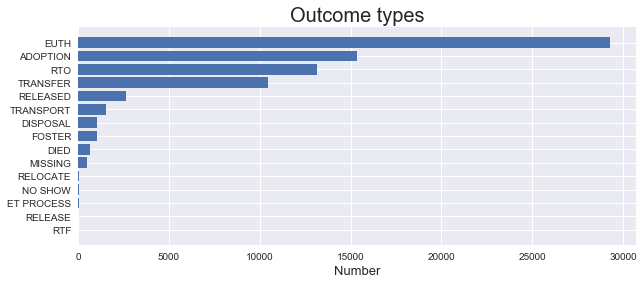

In [24]:
barh(animals_data, 'outcome_type', 'Outcome types', 'Number')

As we are interested mostly into **adopted** pets, our problem can be adjusted to binary or two-class classification where the label which holds the most interesting output for us will get value **1** and all others - **0**.

In [25]:
# Groups size in numbers

animals_data.groupby(animals_data.outcome_type).size().sort_values(ascending = False)

outcome_type
EUTH          29259
ADOPTION      15363
RTO           13126
TRANSFER      10429
RELEASED       2623
TRANSPORT      1558
DISPOSAL       1060
FOSTER         1029
DIED            640
MISSING         483
RELOCATE         54
NO SHOW          34
ET PROCESS       29
RELEASE           5
RTF               5
MISSING EX        2
INDEFINITE        1
dtype: int64

In [26]:
# Group outcome types

animals_data.outcome_type.replace(to_replace='ADOPTION', value=1, inplace=True)
animals_data.outcome_type.replace(regex=[r'^(?!.*ADOPTION).*$'], value=0, inplace=True)

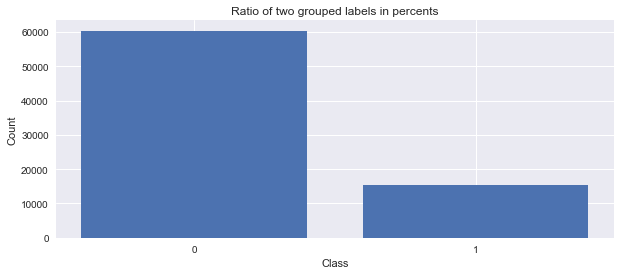

Positive cases: 20.3% of all


In [27]:
# Ratio of two grouped labels in percents

plt.bar([0, 1], [len(animals_data[animals_data.outcome_type == 0]), len(animals_data[animals_data.outcome_type == 1])])
plt.title("Ratio of two grouped labels in percents")
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Positive cases: {:.1f}% of all".format(animals_data.outcome_type.sum() / len(animals_data.outcome_type) * 100))

As seen we have **highly imbalanced** two label groups which should be taken into consideration for data split and model metrics. 

Now when the dataset is more or less clean, we will train and compare a few supervised machine learning classifiers.

# 2. Training, tuning and comparing classification algorithms

### 2.1 Preprocess the data

First step is to separate explanatory features from labels and get indicator variables. 

In [28]:
# Separate features and labels

features = animals_data.drop("outcome_type", axis = 1)
labels = animals_data.outcome_type

In [29]:
# Get indicator variables

features = pd.get_dummies(features)

In [30]:
features.shape

(75700, 265)

There are more than 200 features. We will remove misleading data and noise by decreasing the number of features using Principal Component Analisys (PCA), which should result in increased accuracy and reduce the training time for classifiers. 

#### Choose the number of components in a **PCA**

In [31]:
#Fitting the PCA algorithm with our data

pca = PCA().fit(features)

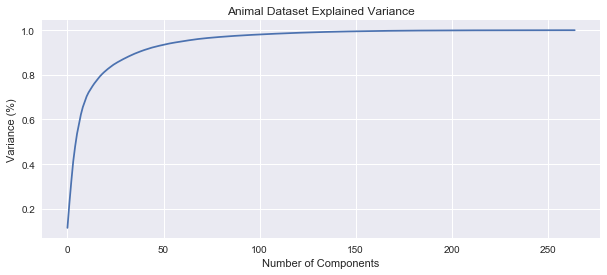

In [32]:
#Plotting the Cumulative Summation of the Explained Variance

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Animal Dataset Explained Variance')
plt.show()

The plot tells us that selecting **100 features** of animal dataset will preserve around 98% variance of the data. We will use this number as a number of components for PCA.

In [33]:
# Implement PCA with the defined number of components

pca = PCA(n_components=100)
features = pca.fit_transform(features)

In [34]:
# The shape of resulting dataset

features.shape

(75700, 100)

### 2.2 Split the data

The next step is to split the data into training and testing set, with 70% of the data for training. Because the output labels are not equaly distributed, we will use the **stratification** based on the `labels`.

In [35]:
# Split train and test data

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, stratify=labels, test_size = 0.2, train_size=0.8)

In [36]:
# Check the shapes of train data

features_train.shape, labels_train.shape

((60560, 100), (60560,))

In [37]:
# Check the shapes of test data

features_test.shape, labels_test.shape

((15140, 100), (15140,))

### 2.3 Train a logistic regression classifier

First of all we will see a baseline score of the model with its **default hyperparameters**:
* `C = 1`
* `max_iter=100`
* `fit_intercept=True`

Afterwards the model will be evaluated by precision and recall metrics. Then we will tune the hyperparameters and evaluate its perfomance once again.

In [38]:
# Train logistic regression classifier with default hyperparameters

model = LogisticRegression()
model.fit(features_train,labels_train)
labels_pred_train = model.predict(features_train)
labels_pred_test = model.predict(features_test)

# Baseline accuracy score of the trained model

model.score(features_train,labels_train)

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7985138705416116

In [39]:
# F1_score of trained data

f1_score(labels_train, labels_pred_train, pos_label = 1)

0.1419127988748242

In [40]:
# F1_score of test data

f1_score(labels_test, labels_pred_test, pos_label = 1)

0.13423959218351741

As seen **accuracy score** which doesn't render an account of label balance is good but the right metrics which should be used in our case is **hamornic score** which is the harmonic mean of the precision and recall. 

In [41]:
# Confusion matrix

confusion_matrix(labels_test,labels_pred_test)

array([[11846,   221],
       [ 2836,   237]], dtype=int64)

In [42]:
# Classification report

print(classification_report(labels_test,labels_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     12067
           1       0.52      0.08      0.13      3073

    accuracy                           0.80     15140
   macro avg       0.66      0.53      0.51     15140
weighted avg       0.75      0.80      0.73     15140



Baseline model has poor perfomance on positive class which we are insterested in. The reason here would be probably a low number of samples of positive class. We will do random over-sampling of minority class to increase the model perfomance.

### Over-sampling

In [43]:
# Class count

count_class_0, count_class_1 = animals_data.outcome_type.value_counts()
count_class_0, count_class_1

(60337, 15363)

In [44]:
# Divide by class

class_0 = animals_data[animals_data['outcome_type'] == 0]
class_1 = animals_data[animals_data['outcome_type'] == 1]

In [45]:
# Random over-sampling of minority class

class_1_oversample = class_1.sample(count_class_0, replace=True)
animals_data = pd.concat([class_0, class_1_oversample], axis=0)

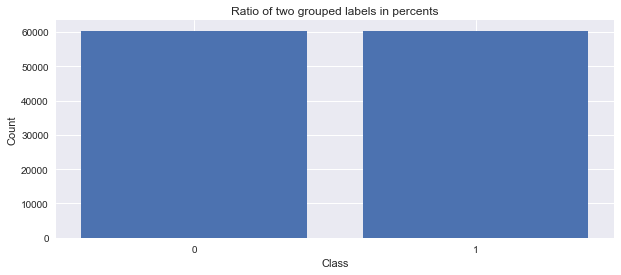

Positive cases: 50.0% of all


In [46]:
# Ratio of two grouped labels in percents

plt.bar([0, 1], [len(animals_data[animals_data.outcome_type == 0]), len(animals_data[animals_data.outcome_type == 1])])
plt.title("Ratio of two grouped labels in percents")
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Positive cases: {:.1f}% of all".format(animals_data.outcome_type.sum() / len(animals_data.outcome_type) * 100))

Now when the data is perfectly balanced, we proceed with logictic baseline model once again and will compare the scores to imbalanced model.

In [47]:
# Separate features and labels

features = animals_data.drop("outcome_type", axis = 1)
labels = animals_data.outcome_type

In [48]:
# Get indicator variables

features = pd.get_dummies(features)
features.shape

(120674, 265)

In [49]:
#Fitting the PCA algorithm with our data

pca = PCA(n_components=100)
features = pca.fit_transform(features)
features.shape

(120674, 100)

In [50]:
# Split train and test data without stratify

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.2, train_size=0.8)

In [51]:
# Check the shapes of train data

features_train.shape, labels_train.shape

((96539, 100), (96539,))

In [52]:
# Check the shapes of test data

features_test.shape, labels_test.shape

((24135, 100), (24135,))

In [53]:
# Train logistic regression classifier with default hyperparameters

model = LogisticRegression()
model.fit(features_train,labels_train)
labels_pred_train = model.predict(features_train)
labels_pred_test = model.predict(features_test)

# Baseline accuracy score of the trained model

model.score(features_train,labels_train)

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7829478241954029

In [54]:
# F1_score of test data

f1_score(labels_train, labels_pred_train, pos_label = 1)

0.8160994190026505

In [55]:
# Classification report

print(classification_report(labels_train,labels_pred_train))

              precision    recall  f1-score   support

           0       0.94      0.60      0.74     48230
           1       0.71      0.96      0.82     48309

    accuracy                           0.78     96539
   macro avg       0.82      0.78      0.78     96539
weighted avg       0.82      0.78      0.78     96539



In [56]:
# Confusion matrix

confusion_matrix(labels_train,labels_pred_train)

array([[29091, 19139],
       [ 1815, 46494]], dtype=int64)

There're high numbers of both:

* **false positive** predictions of adoptions when there was no such an event and 
* **false negative** predictions of no adoption when in fact there was one 

The model has a good recall rate for positive label but low precision which means we do not catch all true positives.

In [57]:
params = {
    'C':[0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_iter':[5, 10, 30, 50],
}
grid_search_logistic_regr = GridSearchCV(LogisticRegression(), params, scoring = 'precision')
grid_search_logistic_regr.fit(features_train, labels_train)

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Fu

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\L

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppDa

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\anastasiy.slavova\AppDa

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000, 100000],
                         'max_iter': [5, 10, 30, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

In [58]:
print("Logistic regression score for trained data:", grid_search_logistic_regr.best_score_)

Logistic regression score for trained data: 0.7085323444261366


In [59]:
grid_search_logistic_regr.best_params_

{'C': 100, 'max_iter': 5}

In [60]:
# results = pd.DataFrame(grid_search_logistic_regr.cv_results_)
# results = results.sort_values(by='mean_test_score', ascending=False)

In [61]:
# results[['param_C', 'param_max_iter', 'mean_test_score']].round(3).head()

In [62]:
# Classification report

print(classification_report(labels_train, grid_search_logistic_regr.predict(features_train)))

              precision    recall  f1-score   support

           0       0.94      0.60      0.74     48230
           1       0.71      0.96      0.82     48309

    accuracy                           0.78     96539
   macro avg       0.82      0.78      0.78     96539
weighted avg       0.82      0.78      0.78     96539



In [63]:
logistic_regr_classifier = grid_search_logistic_regr.best_estimator_

The perfomance of tuned logistic regression classifier for trained data doesn't differ match. Let's see what shows **Precision-Recall curve** which intend do summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. 
The precision and recall can be calculated for thresholds using the precision_recall_curve() function that takes the true output values and the probabilities for the positive class as output and returns the precision, recall and threshold values.

In [64]:
labels_score = logistic_regr_classifier.decision_function(features_test)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

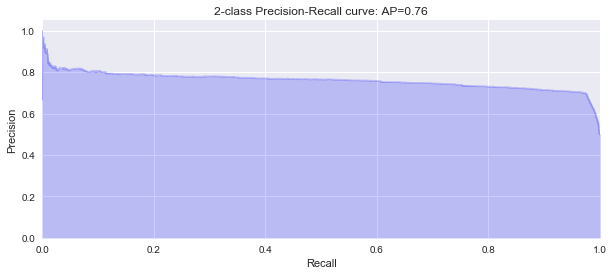

In [65]:
# Precision and recall
precision, recall, _ = precision_recall_curve(labels_test, labels_score)

# Average precision
average_precision = average_precision_score(labels_test, labels_score)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Average precision of the tuned logistic classifier is 76%.

### 2.4 Train a decision tree classifier

We will evaluate the perfomance of baseline decision tree and tune some of its most important hyperparameters:

* `max_depth` - indicates how deep the tree can be. The deeper the tree, the more splits it has and therefore captures more information about the data;
* `min_samples_leaf` - the minimum number of samples at a leaf node;
* `max_leaf_nodes` - the maximum tree nodes numbe. 

First let's fit a decision tree with default hyperparameters:
* `max_depth = None`;
* `min_samples_leaf = 1`;
* `max_leaf_nodes = 1`.

to get a baseline harmonic mean of the precision and recall of its performance.

In [66]:
# Train a desicion tree with the default hyperparameters

tree = DecisionTreeClassifier()
tree.fit(features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [67]:
# f1_score for train data

f1_score(labels_train, tree.predict(features_train))

0.8268815760017909

In [68]:
# precision score for train data

precision_score(labels_train, tree.predict(features_train))

0.7286399646498122

As seen F1 score looks good and pecision is slightly better either. Let's see how we can tune the hyperparameters using AUC metrics visualization. AUC is a good way for evaluation for binary classification problems. First of all we will check `max_depth` hyperparameter. For tuning we will fit a decision tree with depths ranging from 1 to 50 and plot the training and test AUC scores.

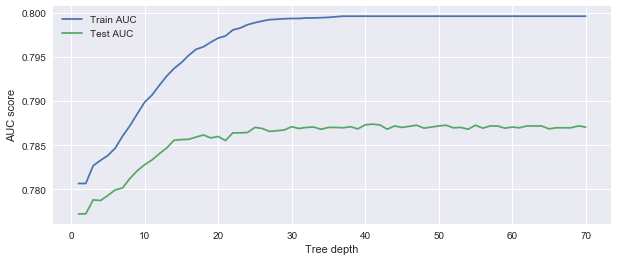

In [69]:
from sklearn.metrics import roc_curve, auc

max_depths = np.linspace(1, 70, 70, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(features_train, labels_train)
    
    train_pred = dt.predict(features_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    
    labels_pred = dt.predict(features_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, labels_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
line1, = plt.plot(max_depths, train_results, label='Train AUC')
line2, = plt.plot(max_depths, test_results, label='Test AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that hyperparameter `depth_tree` greater 30 gives best AUC score for train and test data. The model succeds to generalize the findings for new data as well. Anyway AUC is still under 80%. Let's evaluate `min_samples_leaf` and `max_leaf_nodes` hyperparameters. We will use the same approach and metrics. The range of `min_samples_leaf` will be set from 1 to 30 and for `max_leaf_nodes` from 2 to 800.

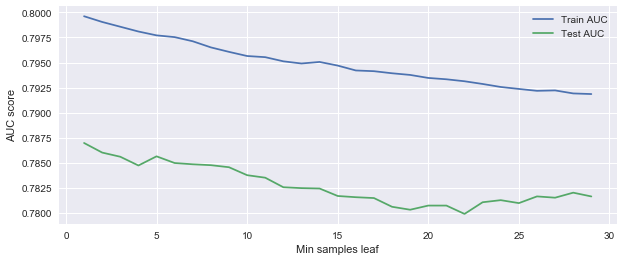

In [70]:
min_samples_leaves = np.arange(1, 30, 1)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leaves:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(features_train, labels_train)
    train_pred = dt.predict(features_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    labels_pred = dt.predict(features_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, labels_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
line1, = plt.plot(min_samples_leaves, train_results, label='Train AUC')
line2, = plt.plot(min_samples_leaves, test_results, label='Test AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Min samples leaf')
plt.show()

The best AUC score we get when `min_samples_leaf` has a low value (AUC is about 60%), AUC is dropping while increasing the number of leaves. Finally let's explore `max_leaf_nodes`.

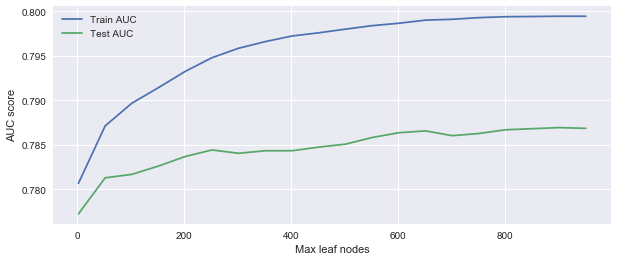

In [71]:
steps = np.arange(2, 1000, 50)
train_results = []
test_results = []
for i in steps:
    dt = DecisionTreeClassifier(max_leaf_nodes=i)
    dt.fit(features_train, labels_train)
    train_pred = dt.predict(features_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    labels_pred = dt.predict(features_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, labels_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
line1, = plt.plot(steps, train_results, label='Train AUC')
line2, = plt.plot(steps, test_results, label='Test AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Max leaf nodes')
plt.show()

We can clearly see that when we consider more than 300 of the samples for `max_leaf_nodes` we will get the best AUC score. But after 900 nodes there is nothing more that can be learnt from the data. Let's check what score we get using selected hyperparameters comparing to baseline score of decision tree model.

In [73]:
params = {
    "max_depth": [20, 30, 40],
    "min_samples_leaf": [1, 5, 10, 15],
    "max_leaf_nodes": [500, 700, 900]
}

grid_search_tree = GridSearchCV(DecisionTreeClassifier(), params, scoring = 'precision')
grid_search_tree.fit(features_train, labels_train)

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [20, 30, 40],
                         'max_leaf_nodes': [500, 700, 900],
                   

In [74]:
tree_classifier = grid_search_tree.best_estimator_

In [75]:
print("Decision tree precision score for train data:", grid_search_tree.best_score_)

Decision tree precision score for train data: 0.7203528383920448


In [76]:
print("Decision tree F1 score for train data:", f1_score(labels_train, tree_classifier.predict(features_train)))

Decision tree F1 score for train data: 0.8269997675208783


In [77]:
grid_search_tree.best_params_

{'max_depth': 40, 'max_leaf_nodes': 900, 'min_samples_leaf': 1}

In [78]:
print(classification_report(labels_train,tree_classifier.predict(features_train)))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76     48230
           1       0.73      0.96      0.83     48309

    accuracy                           0.80     96539
   macro avg       0.83      0.80      0.79     96539
weighted avg       0.83      0.80      0.79     96539



As we see that the hyperparameters we selected using AUC are near to what we get using GridSearchCV with **Precision score**. The tuned model perfomance is slightly better than what we had using default desicion tree model hyperparameters but still is not enough. 

### 2.5 Train Adaboost

AdaBoost classifier combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier.  Let's use AdaBoost with desicion tree classifier and its tuned hyperparameters.

In [80]:
Adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 50)

In [81]:
Adaboost.fit(features_train, labels_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [82]:
# precision score for train data

precision_score(labels_train, tree.predict(features_train))

0.7286399646498122

In [83]:
# F1 score for train data

f1_score(labels_train, Adaboost.predict(features_train))

0.8198047618200893

In [92]:
params = {
    "n_estimators": [50, 100, 300],
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3)), params, scoring = 'precision')

In [93]:
grid_search_ada.fit(features_train, labels_train)

C:\Users\anastasiy.slavova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=3,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                              

In [94]:
ada_classifier = grid_search_ada.best_estimator_

In [95]:
print("AdaBoost precision score for train data:", grid_search_ada.best_score_)

AdaBoost precision score for train data: 0.7197643441244478


In [96]:
print("AdaBoost F1 score for train data::", f1_score(labels_train, tree_classifier.predict(features_train)))

AdaBoost F1 score for train data:: 0.8269997675208783


In [97]:
grid_search_ada.best_params_

{'n_estimators': 300}

### 2.6 Compare the models on test data

Finally we have three trained models and ready to evaluate their perfomance ot test data using precision metrics.

In [98]:
logistic_regr_classifier_score = precision_score(labels_test, logistic_regr_classifier.predict(features_test))
tree_classifier_score = precision_score(labels_test, tree_classifier.predict(features_test))
adaboost_svm_classifier_score = precision_score(labels_test, ada_classifier.predict(features_test))

print("Logistic regression precision score:", logistic_regr_classifier_score)
print("Decision tree precision score:", tree_classifier_score)
print("Adaboost precision score:", adaboost_svm_classifier_score)

Logistic regression precision score: 0.7036563849850946
Decision tree precision score: 0.7152786474639949
Adaboost precision score: 0.7146876758581879


Not high result we got here but anyway all the models have much better prefomance on clean and balanced data. The next step would be to train more complicated models like SVM in order to improve the precision score.

In [99]:
print(classification_report(labels_test, tree_classifier.predict(features_test)))

              precision    recall  f1-score   support

           0       0.93      0.62      0.75     12107
           1       0.72      0.95      0.82     12028

    accuracy                           0.79     24135
   macro avg       0.82      0.79      0.78     24135
weighted avg       0.82      0.79      0.78     24135



In the framework of this project were implemented different kind of technics for preprocessing the data (over-sampling, feature selection, feature engineering, PCA, etc.). Also was implemented a fine tune of each classifier in order to get the best precision and F1 score. As a result, the precision is definitely improved (from 52% to 72%). 


# Rerefencies

* [Loisville Animal Services](https://louisvilleky.gov/government/animal-services)
* [Scikit learn](https://scikit-learn.org/)
* [Fine tuning a classifier in scikit-learn](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65) by Kevin Arvai
* [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/), an article by by Jason Brownlee 
* [InDepth: Parameter tuning for Decision Tree](https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp) by Mohtadi Ben Fraj